In [1]:
import pickle
import numpy as np
import numpy.typing as npt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
from dataclasses import dataclass, field

from forward_models import SOIL_DEPTH_MM, generate_rain, hydrology_model, soil_organic_model, inorganic_nitrogen_model, INORGANIC_N_MODEL_DT_DAYS
import main as main
# from main import NUM_TRIALS_PER_INITIAL_CONDITION, MAX_ACCUMULATED_N, ACCUMULATED_N_GRID_SIZE, ACCUMULATED_N_NUM_STEPS, MOISTURE_NUM_STEPS, AMMONIUM_NUM_STEPS, NITRATE_NUM_STEPS, LEACHING_PENALTIES_USD_PER_M2, N_PRICE_USD_PER_G, PROBABILITY_OF_CLEAR_FORECAST, n_indices_to_values, INITIAL_LITTER_CARBON_GC_PER_M3, INITIAL_LITTER_NITROGEN_GN_PER_M3, INITIAL_MICROBIAL_CARBON_GC_PER_M3, INITIAL_HUMUS_CARBON_GC_PER_M3, values_to_indices, accumulated_N_value_to_index, FORECAST_LOOKAHEAD_DAYS, NITRATE_GRID_SIZE, AMMONIUM_GRID_SIZE
from dp_solver import solve_dp, calculate_probabilities_of_violation, KernelMetadata

In [2]:
CONTROL_TIMESTEP_DAYS = 36
NUM_CONTROL_STEPS = int(36 / CONTROL_TIMESTEP_DAYS)
MAX_SINGLE_STEP_ACCUMULATED_N = min(main.MAX_ACCUMULATED_N, CONTROL_TIMESTEP_DAYS * 15)
SINGLE_STEP_ACCUMULATED_N_NUM_STEPS = int(MAX_SINGLE_STEP_ACCUMULATED_N / main.ACCUMULATED_N_GRID_SIZE)
KERNEL_METADATA = KernelMetadata(main.NUM_TRIALS_PER_INITIAL_CONDITION, NUM_CONTROL_STEPS, main.ACCUMULATED_N_NUM_STEPS, main.MOISTURE_NUM_STEPS, main.AMMONIUM_NUM_STEPS, main.NITRATE_NUM_STEPS, SINGLE_STEP_ACCUMULATED_N_NUM_STEPS)
SELECTED_LEACHING_PENALTY_IDX = 9
SELECTED_LEACHING_PENALTY = main.LEACHING_PENALTIES_USD_PER_M2[SELECTED_LEACHING_PENALTY_IDX]
SELECTED_LEACHING_PENALTY

np.float64(0.20126710688876742)

In [3]:
def moisture_idx_to_value(moisture_idx: int) -> float:
    return main.MOISTURE_GRID_SIZE / 2.0 + main.MOISTURE_GRID_SIZE * moisture_idx

In [4]:
def display_moisture_slice(array_slice: npt.NDArray[np.float64], title: str, from_nitrate: float = None, from_ammonium: float = None, to_nitrate: float = None, to_ammonium: float = None, fig: plt.Figure = None, ax: plt.Axes = None, colorbar=True, **imshow_kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower', **imshow_kwargs)
    if colorbar:
        fig.colorbar(img)

    if from_nitrate is not None and from_ammonium is not None:
        ax.plot([from_nitrate / main.NITRATE_GRID_SIZE], [from_ammonium / main.AMMONIUM_GRID_SIZE], 'o', color="pink")
        if to_nitrate is not None and to_ammonium is not None:
            ax.plot([to_nitrate / main.NITRATE_GRID_SIZE], [to_ammonium / main.AMMONIUM_GRID_SIZE], 'o', color="pink")
            # ax.arrow(from_nitrate, from_ammonium, to_nitrate - from_nitrate, to_ammonium - from_ammonium)
            ax.annotate("", xytext=(from_nitrate / main.NITRATE_GRID_SIZE, from_ammonium / main.AMMONIUM_GRID_SIZE), xy=(to_nitrate / main.NITRATE_GRID_SIZE, to_ammonium / main.AMMONIUM_GRID_SIZE), textcoords="data", arrowprops=dict(arrowstyle="->", color="pink"), annotation_clip=False)
    #     x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
    #     y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
    #     ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    ammonium_ticks = list(np.linspace(0, main.AMMONIUM_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, main.NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    ammonium_labels = []
    for tick in ammonium_ticks:
        ammonium_labels.append(str(round(main.n_indices_to_values(tick, 0)[0], 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(main.n_indices_to_values(0, tick)[1], 3)))

    ax.set_yticks(ammonium_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(ammonium_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Ammonium level (gN/$\\text{m}^3$)")
    ax.set_xlabel("Nitrate level (gN/$\\text{m}^3$)")
    ax.set_title(title)
    return img

def display_ammonium_slice(array_slice: npt.NDArray[np.float64], title: str, from_nitrate: float = None, from_moisture: float = None, to_nitrate: float = None, to_moisture: float = None, fig: plt.Figure = None, ax: plt.Axes = None, colorbar=True, **imshow_kwargs):
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1)
    img = ax.imshow(array_slice, origin='lower', **imshow_kwargs)
    if colorbar:
        fig.colorbar(img)

    if from_nitrate is not None and from_moisture is not None:
        ax.plot([from_nitrate / main.NITRATE_GRID_SIZE], [from_moisture / main.MOISTURE_GRID_SIZE], 'o', color="pink")
        if to_nitrate is not None and from_moisture is not None:
            ax.plot([to_nitrate / main.NITRATE_GRID_SIZE], [from_moisture / main.MOISTURE_GRID_SIZE], 'o', color="pink")
            # ax.arrow(from_nitrate, from_ammonium, to_nitrate - from_nitrate, to_ammonium - from_ammonium)
            ax.annotate("", xytext=(from_nitrate / main.NITRATE_GRID_SIZE, from_moisture / main.AMMONIUM_GRID_SIZE), xy=(to_nitrate / main.NITRATE_GRID_SIZE, from_moisture / main.MOISTURE_GRID_SIZE), textcoords="data", arrowprops=dict(arrowstyle="->", color="pink"), annotation_clip=False)
    #     x_in_log_scale = math.log(point_nitrate / NITRATE_MINIMUM_CELL, NITRATE_SCALE_FACTOR)
    #     y_in_log_scale = math.log(point_ammonium / AMMONIUM_MINIMUM_CELL, AMMONIUM_SCALE_FACTOR)
    #     ax.plot([x_in_log_scale], [y_in_log_scale], 'o', color="pink")

    moisture_ticks = list(np.linspace(0, main.MOISTURE_NUM_STEPS - 1, 6, dtype=np.int32))
    nitrate_ticks = list(np.linspace(0, main.NITRATE_NUM_STEPS - 1, 6, dtype=np.int32))
    moisture_labels = []
    for tick in moisture_ticks:
        moisture_labels.append(str(round(moisture_idx_to_value(tick), 3)))
    nitrate_labels = []
    for tick in nitrate_ticks:
        nitrate_labels.append(str(round(main.n_indices_to_values(0, tick)[1], 3)))

    ax.set_yticks(moisture_ticks)
    ax.set_xticks(nitrate_ticks)
    ax.set_yticklabels(moisture_labels)
    ax.set_xticklabels(nitrate_labels)
    ax.set_ylabel("Moisture")
    ax.set_xlabel("Nitrate level (gN/$\\text{m}^3$)")
    ax.set_title(title)
    return img

def moisture_idx_to_string(moisture_index: int) -> str:
    return str(round(indices_to_values(0, moisture_index, 0, 0)[1], 3))

In [5]:
with open(str(CONTROL_TIMESTEP_DAYS) + "_transition_counts.pickle", 'rb') as f:
    transition_counts = pickle.load(f)
with open(str(CONTROL_TIMESTEP_DAYS) + "_expected_plant_N_deficit.pickle", 'rb') as f:
    expected_plant_N_deficit_cost_USD = pickle.load(f)

In [6]:
controllers = []
leaching_penalty_indicies = [0, 9, 18]
for leaching_penalty_idx in leaching_penalty_indicies:
    controllers.append(solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, KERNEL_METADATA, main.N_PRICE_USD_PER_G, (SOIL_DEPTH_MM / 1000.), main.n_indices_to_values, main.LEACHING_PENALTIES_USD_PER_M2[leaching_penalty_idx], main.PROBABILITY_OF_CLEAR_FORECAST))

In [7]:
# optimal_cost_to_go_USD_per_m2, optimal_ammonium_add_in_cells, optimal_nitrate_add_in_cells = solve_dp(transition_counts, expected_plant_N_deficit_cost_USD, KERNEL_METADATA, main.N_PRICE_USD_PER_G, (SOIL_DEPTH_MM / 1000.), main.n_indices_to_values, SELECTED_LEACHING_PENALTY, main.PROBABILITY_OF_CLEAR_FORECAST)

In [8]:
# probabilities_of_violation = calculate_probabilities_of_violation(transition_counts, optimal_ammonium_add_in_cells, optimal_nitrate_add_in_cells, KERNEL_METADATA, main.PROBABILITY_OF_CLEAR_FORECAST)

In [9]:
@dataclass
class RolloutResult:
    total_nitrogen_deficit_cost: float
    ammonium_nitrogen_g_per_m3: npt.NDArray[np.float64]
    nitrate_nitrogen_g_per_m3: npt.NDArray[np.float64]
    plant_passive_uptake_of_ammonium_gN_per_m3_per_day: npt.NDArray[np.float64]
    plant_passive_uptake_of_nitrate_gN_per_m3_per_day: npt.NDArray[np.float64]
    plant_active_uptake_of_ammonium_gN_per_m3_per_day: npt.NDArray[np.float64]
    plant_active_uptake_of_nitrate_gN_per_m3_per_day: npt.NDArray[np.float64]
    ammonium_adds: npt.NDArray[np.float64]
    nitrate_adds: npt.NDArray[np.float64]
    soil_moisture: npt.NDArray[np.float64]
    transpiration_rate_mm_per_day: npt.NDArray[np.float64]
    leakage_rate_mm_per_day: npt.NDArray[np.float64]
    ammonium_leaching_gN_per_m3_per_day: npt.NDArray[np.float64]
    nitrate_leaching_gN_per_m3_per_day: npt.NDArray[np.float64]
    plant_accumulated_N_gN_per_m3: npt.NDArray[np.float64]
    leaching_violated: bool
    leaching_limit_violated_per_step: npt.NDArray[np.bool]
    forecasts: npt.NDArray[np.float64]

    total_plant_N_uptake_gN_per_m3_per_day: npt.NDArray[np.float64] = field(init=False)

    def __post_init__(self):
        self.total_plant_N_uptake_gN_per_m3_per_day = self.plant_passive_uptake_of_ammonium_gN_per_m3_per_day + self.plant_passive_uptake_of_nitrate_gN_per_m3_per_day + self.plant_active_uptake_of_ammonium_gN_per_m3_per_day + self.plant_active_uptake_of_nitrate_gN_per_m3_per_day

In [10]:
def run_controller(control_period_days: int, num_control_periods: int,
                   initial_soil_moisture: float, initial_ammonium_gN_per_m3: float, 
                   initial_nitrate_gN_per_m3: float, 
                   optimal_cost_to_go_USD_per_m2,
                   optimal_ammonium_add_in_cells,
                   optimal_nitrate_add_in_cells,
                   rain_quantity_mm = None,
                   initial_litter_carbon_gC_per_m3: float = main.INITIAL_LITTER_CARBON_GC_PER_M3,
                   initial_litter_nitrogen_gN_per_m3: float = main.INITIAL_LITTER_NITROGEN_GN_PER_M3,
                   initial_microbial_carbon_gC_per_m3: float = main.INITIAL_MICROBIAL_CARBON_GC_PER_M3, 
                   initial_humus_carbon_gC_per_m3: float = main.INITIAL_HUMUS_CARBON_GC_PER_M3, 
                   generate_figures: bool = True) -> RolloutResult:
    if rain_quantity_mm is None:
        rain_quantity_mm = generate_rain(control_period_days * num_control_periods)
    soil_moisture, _, _, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, moisture_effect_on_decomposition_factor, moisture_effect_on_nitrification_factor = hydrology_model(initial_soil_moisture, rain_quantity_mm)

    _, _, biomass_carbon_g_per_m3, _, net_flux_to_mineralized_nitrogen_g_per_m3_per_day = soil_organic_model(initial_litter_carbon_gC_per_m3, initial_litter_nitrogen_gN_per_m3, initial_microbial_carbon_gC_per_m3, initial_humus_carbon_gC_per_m3, moisture_effect_on_decomposition_factor, np.zeros(control_period_days * num_control_periods), np.zeros(control_period_days * num_control_periods))

    ammonium_gN_per_m3 = initial_ammonium_gN_per_m3
    nitrate_gN_per_m3 = initial_nitrate_gN_per_m3
    accumulated_N_gN_per_m3 = 0
    ammonium_adds = np.zeros(num_control_periods)
    nitrate_adds = np.zeros(num_control_periods)
    forecasts = np.ndarray(num_control_periods)
    total_ammonium_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_nitrogen_g_per_m3 = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_ammonium_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_active_uptake_of_nitrate_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrate_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_ammonium_leaching_gN_per_m3_per_day = np.ndarray(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_plant_accumulated_N_gN_per_m3 = np.zeros(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS))
    total_nitrogen_deficit_cost = 0
    leaching_violated_yet = 0
    leaching_limit_violated_per_step = np.ndarray(num_control_periods, np.bool)

    for i in range(num_control_periods):
        start_day = i * control_period_days
        end_day = (i + 1) * control_period_days

        indices = main.values_to_indices(soil_moisture[i * control_period_days], ammonium_gN_per_m3, nitrate_gN_per_m3)
        accumulated_N_index = main.accumulated_N_value_to_index(accumulated_N_gN_per_m3)
        is_rain_forecast = int(any(rain_quantity_mm[start_day:start_day+main.FORECAST_LOOKAHEAD_DAYS] > 0))
        forecasts[i] = is_rain_forecast
        target_ammonium_index = optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[1]
        target_nitrate_index = optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index, is_rain_forecast, *indices] + indices[2]
        if target_ammonium_index == indices[1]:
            ammonium_adds[i] = 0
        else:
            ammonium_adds[i] = main.n_indices_to_values(target_ammonium_index, 0)[0] - ammonium_gN_per_m3
        if target_nitrate_index == indices[2]:
            nitrate_adds[i] = 0
        else:
            nitrate_adds[i] = main.n_indices_to_values(0, target_nitrate_index)[1] - nitrate_gN_per_m3

        if generate_figures:
            fig, axs = plt.subplots(1, 4, figsize=[7*4, 4.8])

            forecast_str = "rain" if is_rain_forecast == 1 else "clear"
            violated_str = "violated" if leaching_violated_yet == 1 else "unviolated"


            display_moisture_slice(np.sum(transition_counts[i, is_rain_forecast, indices[0], :, :, 1], (2, 3, 4, 5), np.float64) / main.NUM_TRIALS_PER_INITIAL_CONDITION, "Probability of violation at step " + str(i) + "\nwith moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0], vmin=0.0, vmax=1.0)
            # display_moisture_slice(optimal_ammonium_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * AMMONIUM_GRID_SIZE, "Optimal ammonium add for step " + str(i) + "\nwith moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str + ", " + violated_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[0], vmin=0.0, vmax=MAX_AMMONIUM)
            display_moisture_slice(optimal_nitrate_add_in_cells[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]] * main.NITRATE_GRID_SIZE, "Optimal nitrate add for step " + str(i) + "\nwith moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str + ", " + violated_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[1])
            display_moisture_slice(optimal_cost_to_go_USD_per_m2[i, leaching_violated_yet, accumulated_N_index,  is_rain_forecast, indices[0]], "Optimal cost to go for step " + str(i) + "\nwith moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str + ", " + violated_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2])
            # display_moisture_slice(high_fine_probabilities_of_violation[i, accumulated_N_index, is_rain_forecast, indices[0]], "Probability of violation from step " + str(i) + "\nwith moisture " + str(round(soil_moisture[i * control_period_days], 2)) + ", " + forecast_str, from_nitrate=nitrate_gN_per_m3, from_ammonium=ammonium_gN_per_m3, to_nitrate=nitrate_gN_per_m3 + nitrate_adds[i], to_ammonium=ammonium_gN_per_m3 + ammonium_adds[i], fig=fig, ax=axs[2], vmin=0.0, vmax=1.0)
            axs[3].set_title("N accumulation progress")
            x_series = np.arange(int(control_period_days * num_control_periods / INORGANIC_N_MODEL_DT_DAYS)) * INORGANIC_N_MODEL_DT_DAYS
            axs[3].plot(x_series[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[:int(start_day / INORGANIC_N_MODEL_DT_DAYS)], label="actual")
            axs[3].plot(x_series, main.biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(main.day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.), label="N_crit")
            axs[3].set_ylabel("Total plant N accumulation (gN/m^3)")
            axs[3].set_xlabel("Day")
            axs[3].legend(loc="upper left")

        ammonium_gN_per_m3 = ammonium_gN_per_m3 + ammonium_adds[i]
        nitrate_gN_per_m3 = nitrate_gN_per_m3 + nitrate_adds[i]

        ammonium_nitrogen_g_per_m3, nitrate_nitrogen_g_per_m3, ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, assumptions_violation, _ = inorganic_nitrogen_model(ammonium_gN_per_m3, nitrate_gN_per_m3, float(i * control_period_days), leakage_rate_mm_per_day[start_day : end_day], transpiration_rate_mm_per_day[start_day : end_day], soil_moisture[start_day : end_day], net_flux_to_mineralized_nitrogen_g_per_m3_per_day[start_day : end_day], biomass_carbon_g_per_m3[start_day : end_day], main.day_to_plant_N_demand_gN_per_m3_per_day, output_dt_days=INORGANIC_N_MODEL_DT_DAYS)

        # total_nitrogen_deficit_cost += nitrogen_deficit_cost(plant_passive_uptake_of_ammonium_gN_per_m3_per_day, plant_active_uptake_of_ammonium_gN_per_m3_per_day, PLANT_AMMONIUM_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS) + nitrogen_deficit_cost(plant_passive_uptake_of_nitrate_gN_per_m3_per_day, plant_active_uptake_of_nitrate_gN_per_m3_per_day, PLANT_NITRATE_DEMAND_GRAMS_N_PER_M3_PER_DAY, INORGANIC_N_MODEL_DT_DAYS)
        total_ammonium_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_nitrogen_g_per_m3
        total_nitrate_nitrogen_g_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_nitrogen_g_per_m3
        total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_passive_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_active_uptake_of_ammonium_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_ammonium_gN_per_m3_per_day
        total_plant_active_uptake_of_nitrate_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_nitrate_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = nitrate_leaching_gN_per_m3_per_day
        total_ammonium_leaching_gN_per_m3_per_day[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = ammonium_leaching_gN_per_m3_per_day

        combined_N_uptake = plant_passive_uptake_of_ammonium_gN_per_m3_per_day + plant_passive_uptake_of_nitrate_gN_per_m3_per_day + plant_active_uptake_of_ammonium_gN_per_m3_per_day + plant_active_uptake_of_nitrate_gN_per_m3_per_day
        total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)] = np.cumsum(combined_N_uptake * INORGANIC_N_MODEL_DT_DAYS) + accumulated_N_gN_per_m3
        total_nitrogen_deficit_cost += main.nitrogen_deficit_cost(total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], float(start_day), INORGANIC_N_MODEL_DT_DAYS)
        accumulated_N_gN_per_m3 = total_plant_accumulated_N_gN_per_m3[int(end_day / INORGANIC_N_MODEL_DT_DAYS) - 1]

        if generate_figures:
            axs[3].plot(x_series[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):int(end_day / INORGANIC_N_MODEL_DT_DAYS)], color="tab:blue", linestyle="dotted")

        ammonium_gN_per_m3 = ammonium_nitrogen_g_per_m3[-1]
        nitrate_gN_per_m3 = nitrate_nitrogen_g_per_m3[-1]
        leaching_limit_violated_per_step[i] = main.leaching_limit_violated(leakage_rate_mm_per_day[start_day : end_day], ammonium_leaching_gN_per_m3_per_day, nitrate_leaching_gN_per_m3_per_day, INORGANIC_N_MODEL_DT_DAYS)
        if leaching_violated_yet == 0:
            leaching_violated_yet = int(leaching_limit_violated_per_step[i])

    # inelegant hack
    # axs[3].plot(x_series[int(start_day / INORGANIC_N_MODEL_DT_DAYS):], total_plant_accumulated_N_gN_per_m3[int(start_day / INORGANIC_N_MODEL_DT_DAYS):], color="tab:blue", linestyle="dotted")

    return RolloutResult(total_nitrogen_deficit_cost, total_ammonium_nitrogen_g_per_m3, total_nitrate_nitrogen_g_per_m3, total_plant_passive_uptake_of_ammonium_gN_per_m3_per_day, total_plant_passive_uptake_of_nitrate_gN_per_m3_per_day, total_plant_active_uptake_of_ammonium_gN_per_m3_per_day, total_plant_active_uptake_of_nitrate_gN_per_m3_per_day, ammonium_adds, nitrate_adds, soil_moisture, transpiration_rate_mm_per_day, leakage_rate_mm_per_day, total_ammonium_leaching_gN_per_m3_per_day, total_nitrate_leaching_gN_per_m3_per_day, total_plant_accumulated_N_gN_per_m3, leaching_violated_yet == 1 , leaching_limit_violated_per_step, forecasts)

In [11]:
test_rainfall = generate_rain(CONTROL_TIMESTEP_DAYS * NUM_CONTROL_STEPS)
print(test_rainfall)

[14.69102027  0.          0.          0.          0.          0.
  0.         44.01066784  0.          0.          6.86199038  0.
  0.         10.61972756  0.          0.          0.          0.
  0.         14.03852969  6.18638611 16.13088163  0.          0.
  0.          0.         18.20764675 10.18671759 16.20730183  0.
  0.          0.          0.          0.          0.          0.        ]


Lost yield due to N deficit: $0.003 (1.3%)
Revenue: $0.265
Expenditures: $0.027
Profit: $0.238
Leaching limit violated: True
Lost yield due to N deficit: $0.018 (6.7%)
Revenue: $0.250
Expenditures: $0.022
Profit: $0.228
Leaching limit violated: True
Lost yield due to N deficit: $0.259 (96.6%)
Revenue: $0.009
Expenditures: $0.000
Profit: $0.009
Leaching limit violated: False


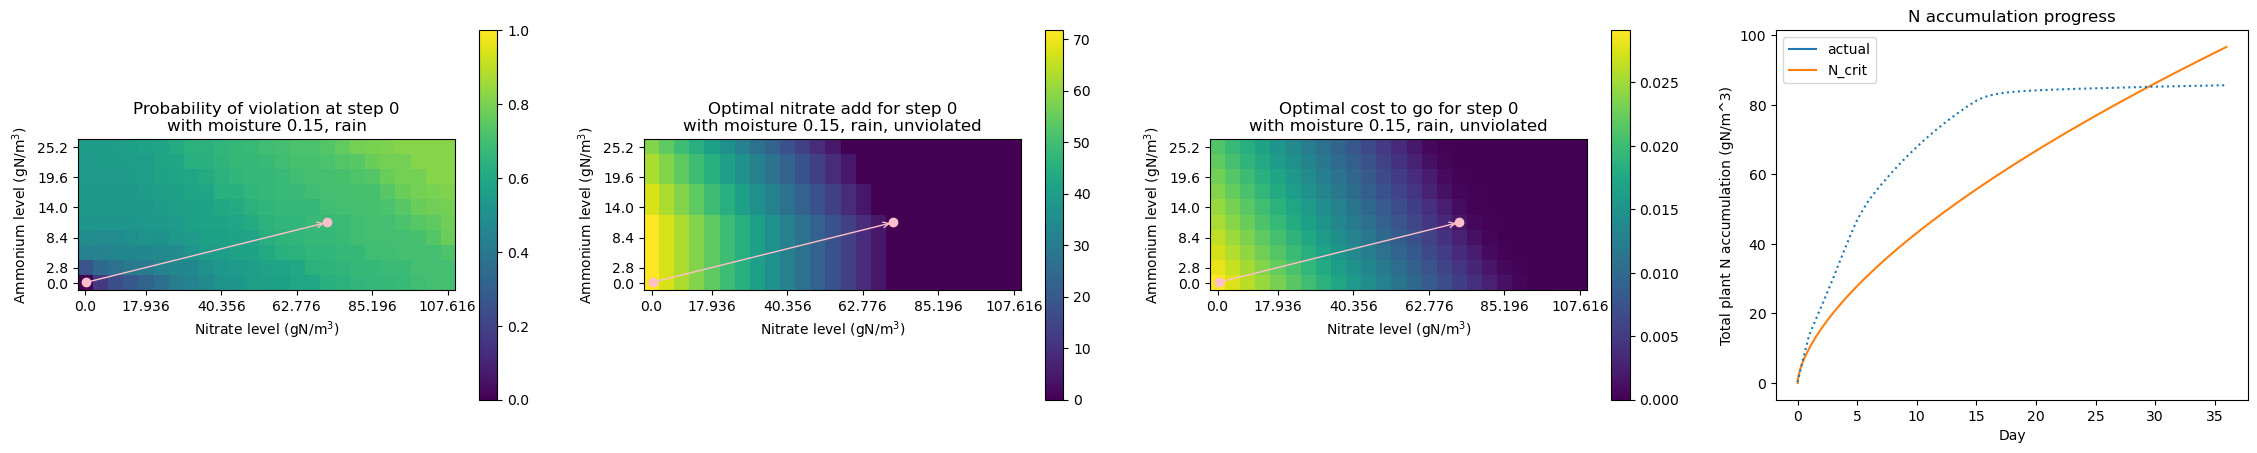

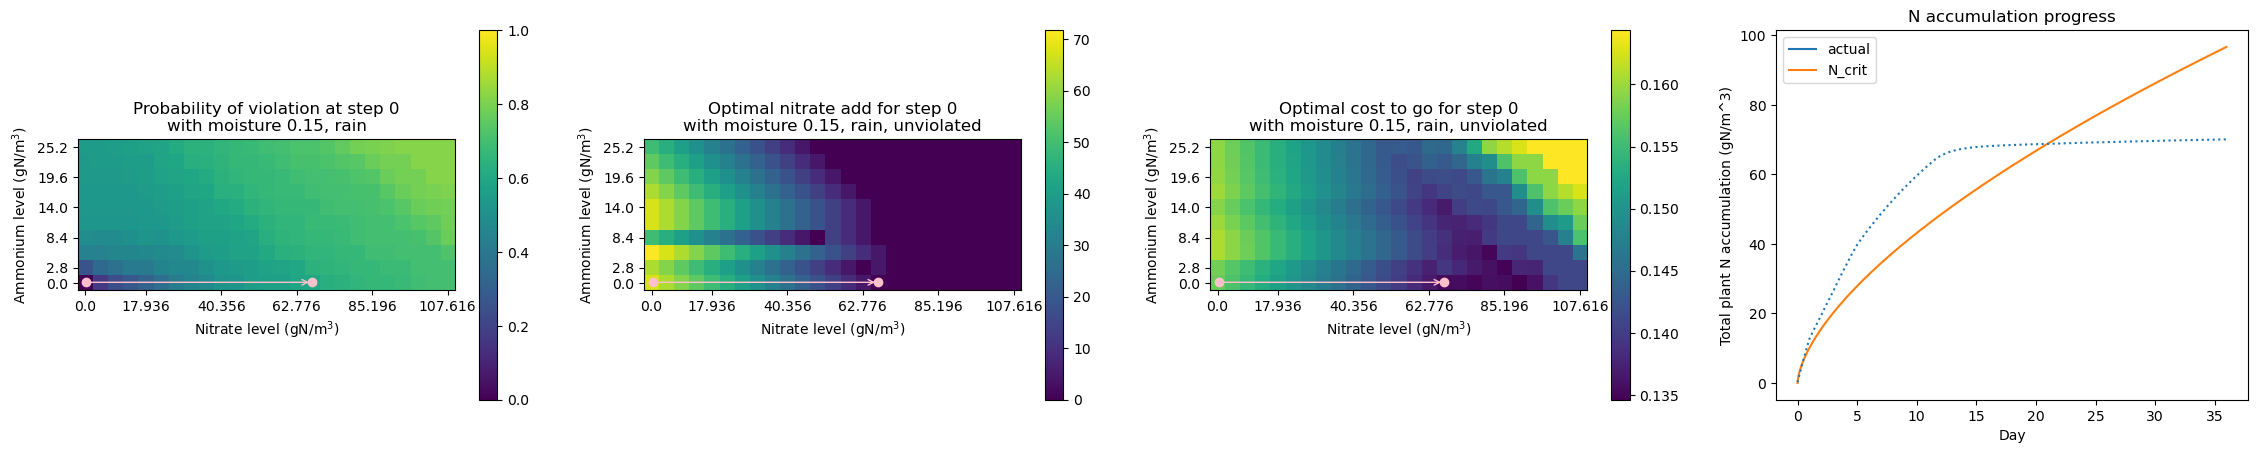

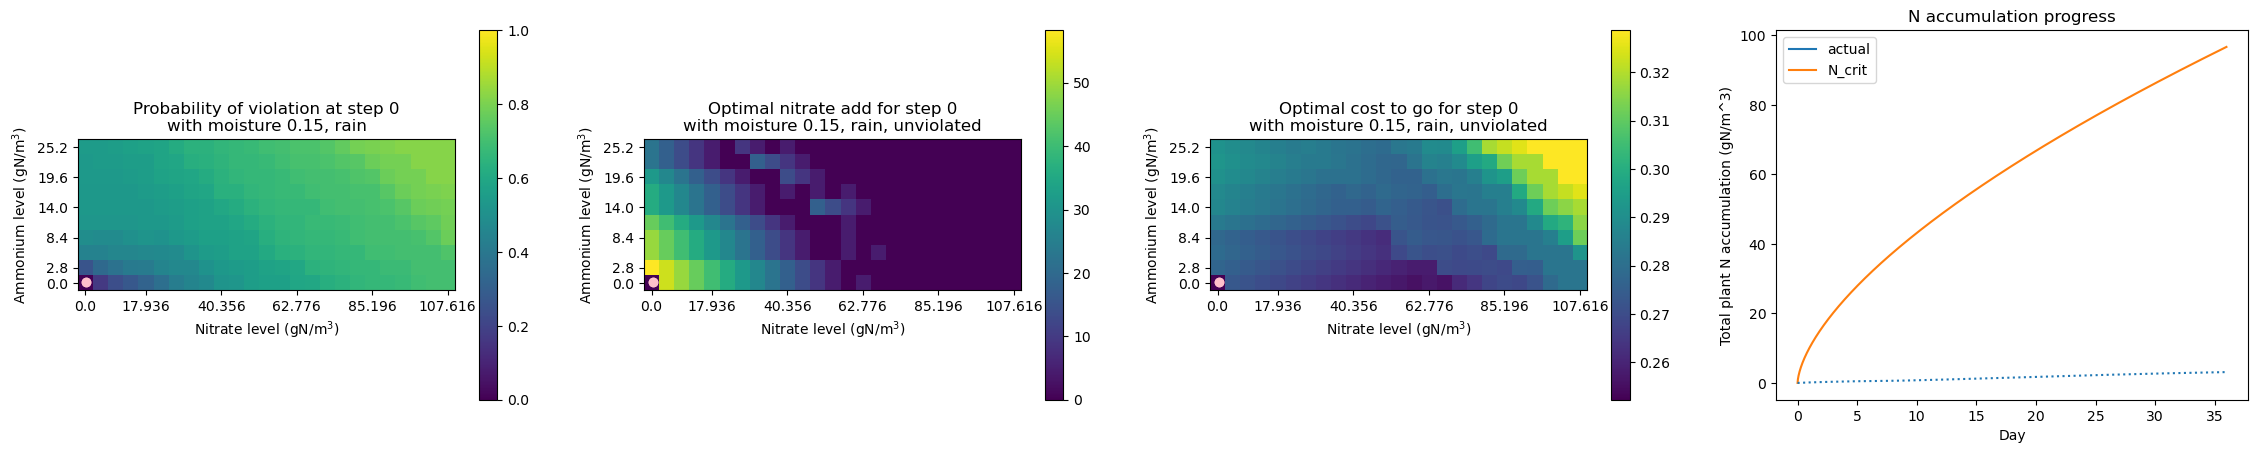

In [12]:
rollouts_by_controller = []
for controller in controllers:
    rollout_result = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3, controller[0], controller[1], controller[2], rain_quantity_mm=test_rainfall, generate_figures=True)
    rollouts_by_controller.append(rollout_result)
    revenue = main.N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * main.CORN_PRICE_USD_PER_G_GRAIN - rollout_result.total_nitrogen_deficit_cost
    expenditures = (np.sum(rollout_result.ammonium_adds) + np.sum(rollout_result.nitrate_adds)) * (SOIL_DEPTH_MM / 1000.) * main.N_PRICE_USD_PER_G
    print("Lost yield due to N deficit: ${:.3f} ({:.1f}%)\nRevenue: ${:.3f}\nExpenditures: ${:.3f}\nProfit: ${:.3f}".format(rollout_result.total_nitrogen_deficit_cost, rollout_result.total_nitrogen_deficit_cost / (main.N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 * main.CORN_PRICE_USD_PER_G_GRAIN) * 100.0, revenue, expenditures, revenue - expenditures))
    print("Leaching limit violated:", rollout_result.leaching_violated)

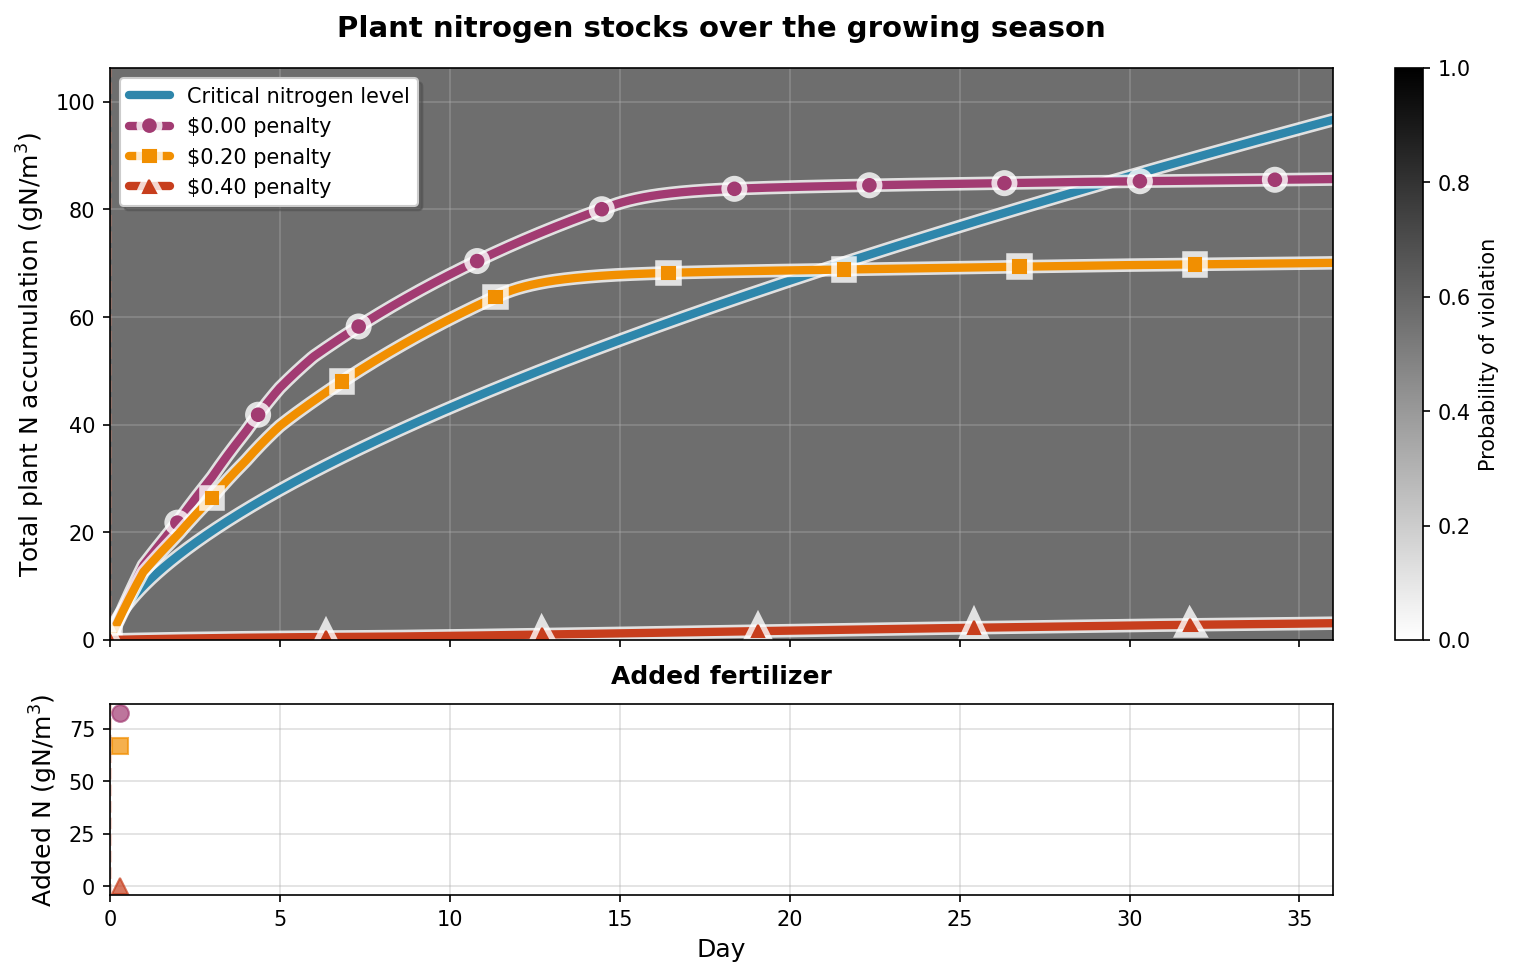

In [13]:
# Modern color palette
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#BC4B51']
line_styles = ['--', '-.', ':']
markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

fig, (ax, lower_ax) = plt.subplots(2, 1, sharex=True, height_ratios=[3, 1], figsize=[10, 6.4], layout='constrained', dpi=150)

ax.set_title("Plant nitrogen stocks over the growing season", fontsize=14, fontweight='bold', pad=15)
x_series = np.arange(len(rollouts_by_controller[0].plant_passive_uptake_of_ammonium_gN_per_m3_per_day)) * INORGANIC_N_MODEL_DT_DAYS

# Draw colored blocks FIRST (behind everything else)
cmap = mpl.colormaps['binary']
n_crit = main.biomass_g_per_m2_to_critical_nitrogen_gN_per_m2(main.day_to_biomass_g_per_m2(x_series)) / (SOIL_DEPTH_MM / 1000.)
y_max = np.max(n_crit)
for rollout in rollouts_by_controller:
    y_max = max(y_max, np.sum(rollout.total_plant_N_uptake_gN_per_m3_per_day) * INORGANIC_N_MODEL_DT_DAYS)
y_max *= 1.1
x_max = NUM_CONTROL_STEPS * CONTROL_TIMESTEP_DAYS

for i in range(NUM_CONTROL_STEPS):
    day = i * CONTROL_TIMESTEP_DAYS
    inorganic_n_model_idx = int(day / INORGANIC_N_MODEL_DT_DAYS)
    probability_of_violation = np.sum(transition_counts[i, int(rollouts_by_controller[0].forecasts[i]), *main.values_to_indices(rollouts_by_controller[0].soil_moisture[day], 0, 60), 1]) / main.NUM_TRIALS_PER_INITIAL_CONDITION
    probability_of_violation = min(1.0, probability_of_violation)
    ax.fill([day, day, day + CONTROL_TIMESTEP_DAYS, day + CONTROL_TIMESTEP_DAYS], [0, y_max, y_max, 0], color=cmap(probability_of_violation), zorder=0, linewidth=0)

# Now draw lines on top with white outlines for visibility
ax.plot(x_series, n_crit, label="Critical nitrogen level", color=colors[0], linewidth=4, alpha=1, zorder=2, solid_capstyle='round', path_effects=[path_effects.Stroke(linewidth=6.5, foreground='white', alpha=0.8), path_effects.Normal()])
for idx, leaching_penalty_idx in enumerate(leaching_penalty_indicies):
    leaching_penalty_USD = main.LEACHING_PENALTIES_USD_PER_M2[leaching_penalty_idx]
    plant_accumulated_N = np.cumsum(rollouts_by_controller[idx].total_plant_N_uptake_gN_per_m3_per_day * INORGANIC_N_MODEL_DT_DAYS)
    ax.plot(x_series,
            plant_accumulated_N, 
            label="${:04.2f} penalty".format(leaching_penalty_USD), 
            color=colors[1 + idx],
            # linestyle=line_styles[idx],
            marker=markers[idx],
            markersize=6,
            markevery=0.1 + 0.03 * idx,
            linewidth=4, 
            alpha=1, 
            zorder=2, 
            solid_capstyle='round', 
            path_effects=[path_effects.Stroke(linewidth=6.5, foreground='white', alpha=0.8), path_effects.Normal()])

ax.vlines(np.linspace(0, x_max, NUM_CONTROL_STEPS, endpoint=False), 0, y_max, color='#E07A5F', alpha=0.3, linestyles="dashed", linewidth=1.5, zorder=1)

ax.set_ylabel("Total plant N accumulation (gN/$\\text{m}^3$)", fontsize=12)
ax.set_xlim(0, x_max)
ax.set_ylim(0, y_max)

cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label('Probability of violation', fontsize=10)

ax.legend(loc="upper left", frameon=True, shadow=True, fontsize=10)
ax.grid(True, alpha=0.4, zorder=1)

# Lower subplot with modern styling
for idx, rollout in enumerate(rollouts_by_controller):
    lower_ax.plot(np.linspace(0, x_max, len(rollout.nitrate_adds) + 1)[:-1] + 0.3, rollout.nitrate_adds + rollout.ammonium_adds, markers[idx],
                     color=colors[idx + 1],
                     alpha=0.7,
                     markersize=8)
lower_ax.set_title("Added fertilizer", fontsize=12, fontweight='bold', pad=10)
lower_ax.set_xlabel("Day", fontsize=12)
lower_ax.set_ylabel("Added N (gN/$\\text{m}^3$)", fontsize=12)

for x in np.linspace(0, x_max, NUM_CONTROL_STEPS, endpoint=False):
    lower_ax.axvline(x, color='#E07A5F', alpha=0.3, linestyle="dashed", linewidth=1.5)

lower_ax.grid(True, alpha=0.4)

fig.savefig("mixed_violating_trajectory.png", transparent=True, dpi=300, bbox_inches='tight')

In [14]:
num_rollouts_batch = 400
try:
    with open("rollout_rainfalls.pkl", 'rb') as f:
        rollout_rainfalls = pickle.load(f)
except FileNotFoundError:
    rollout_rainfalls = []
    for i in range(num_rollouts_batch):
        rollout_rainfalls.append(generate_rain(CONTROL_TIMESTEP_DAYS * NUM_CONTROL_STEPS))
    with open("rollout_rainfalls.pkl", 'wb') as f:
        pickle.dump(rollout_rainfalls, f)

In [15]:
rollout_rainfalls

[array([ 0.        ,  0.        , 30.67699859, 13.93950512,  0.        ,
         0.        ,  0.        ,  3.95742198,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 12.6820349 ,
         0.        , 32.78558037,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        12.39345128,  0.        ,  0.        ,  0.        ,  0.        ,
         9.31514936, 18.93447643,  0.        ,  0.        ,  0.        ,
         0.        ]),
 array([ 0.        ,  0.        ,  0.        , 20.5452875 ,  0.        ,
         0.        ,  0.        ,  0.        , 16.00885787,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 13.08905963, 13.29684107,  0.        ,  0.        ,
         2.5413099 ,  0.        ,  0.        , 67.44414273,  0.        ,
         0.        ,  0.        , 10.39988023,  0.        ,  0.        ,
        12.78453803,  0.    

In [16]:
batch_rollout_results = np.zeros((len(controllers) * num_rollouts_batch, 4))
for controller_idx, controller in enumerate(controllers):
    for i in range(num_rollouts_batch):
        rollout_result = run_controller(CONTROL_TIMESTEP_DAYS, NUM_CONTROL_STEPS, 0.15, 0.105, 0.3, controller[0], controller[1], controller[2], rain_quantity_mm=rollout_rainfalls[i], generate_figures=False)
        total_leaching_gN_per_m2 = np.sum(rollout_result.ammonium_leaching_gN_per_m3_per_day + rollout_result.nitrate_leaching_gN_per_m3_per_day) * INORGANIC_N_MODEL_DT_DAYS  * (SOIL_DEPTH_MM / 1000.)
        batch_rollout_results[controller_idx * num_rollouts_batch + i] = [main.LEACHING_PENALTIES_USD_PER_M2[leaching_penalty_indicies[controller_idx]], rollout_result.total_nitrogen_deficit_cost, total_leaching_gN_per_m2, rollout_result.leaching_violated]

In [17]:
results_df = pd.DataFrame(batch_rollout_results, columns=["penalty", "deficit_cost", "total_leaching_gN_per_m2", "violated"])
results_df.to_csv(str(CONTROL_TIMESTEP_DAYS) + "_days_rollouts.csv", index=False)
results_df

,penalty,deficit_cost,total_leaching_gN_per_m2,violated
0,0.000000,0.003384,0.009969,1.0
1,0.000000,0.003823,0.003828,0.0
2,0.000000,0.004116,0.000000,0.0
3,0.000000,0.010326,2.637280,1.0
4,0.000000,0.004076,0.000000,0.0
...,...,...,...,...
1195,0.402534,0.259405,0.001458,0.0
1196,0.402534,0.260275,0.004598,0.0
1197,0.402534,0.259441,0.000218,0.0
1198,0.402534,0.067371,0.002306,1.0


In [18]:
results_df.groupby("penalty").quantile(0.95)

,deficit_cost,total_leaching_gN_per_m2,violated
penalty,,,
0.000000,0.009778,2.412545,1.0
0.201267,0.056317,1.005590,1.0
0.402534,0.262007,0.025076,1.0


In [19]:
results_df.groupby("penalty").mean()

,deficit_cost,total_leaching_gN_per_m2,violated
penalty,,,
0.000000,0.004836,0.365094,0.6025
0.201267,0.032872,0.189291,0.5025
0.402534,0.191043,0.007290,0.1100


In [20]:
results_df['penalty'].unique()

array([0.        , 0.20126711, 0.40253421])

In [21]:
any(results_df['penalty'] == results_df['penalty'].unique()[1])

True

In [22]:
extreme_results = results_df[((results_df["penalty"] == 0) & (results_df["total_leaching_gN_per_m2"] >= 1.862629)) | ((results_df["penalty"] == results_df['penalty'].unique()[1]) & (results_df["total_leaching_gN_per_m2"] >= 1.561432)) | ((results_df["penalty"] == results_df['penalty'].unique()[2]) & (results_df["total_leaching_gN_per_m2"] >= 1.601419))]

In [23]:
results_df[results_df["violated"] == 1]

,penalty,deficit_cost,total_leaching_gN_per_m2,violated
0,0.000000,0.003384,0.009969,1.0
3,0.000000,0.010326,2.637280,1.0
7,0.000000,0.028788,6.858930,1.0
8,0.000000,0.003760,0.012962,1.0
9,0.000000,0.003695,0.141313,1.0
...,...,...,...,...
1171,0.402534,0.068532,0.005330,1.0
1173,0.402534,0.068186,0.004775,1.0
1178,0.402534,0.065862,0.069988,1.0
1186,0.402534,0.065903,0.020472,1.0


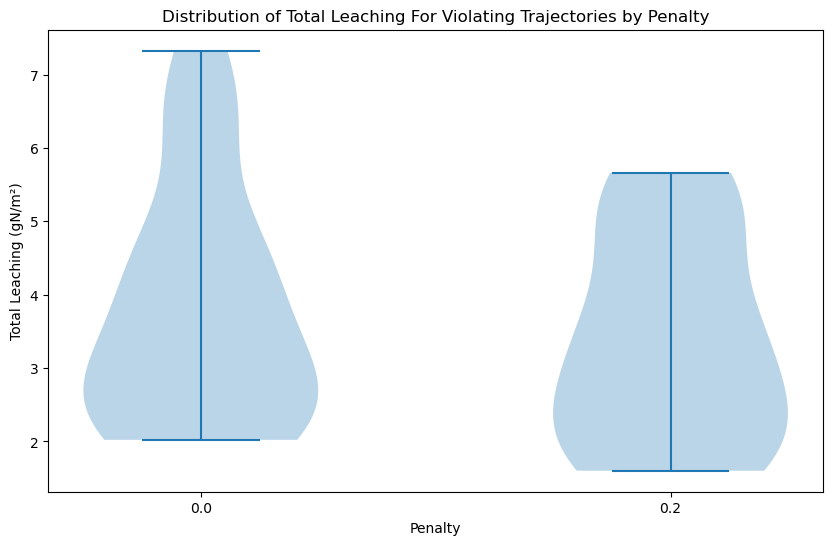

In [24]:
leaching_by_penalty = [group['total_leaching_gN_per_m2'].values for name, group in extreme_results.groupby('penalty')]

# Get the penalty labels for the x-axis
penalty_labels = np.round(extreme_results['penalty'].unique(), 2)

# Create the violin plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.violinplot(leaching_by_penalty)

# Set x-axis labels
ax.set_xticks(range(1, len(penalty_labels) + 1))
ax.set_xticklabels(penalty_labels)

ax.set_ylabel('Total Leaching (gN/m²)')
ax.set_xlabel('Penalty')
ax.set_title('Distribution of Total Leaching For Violating Trajectories by Penalty')
plt.show()

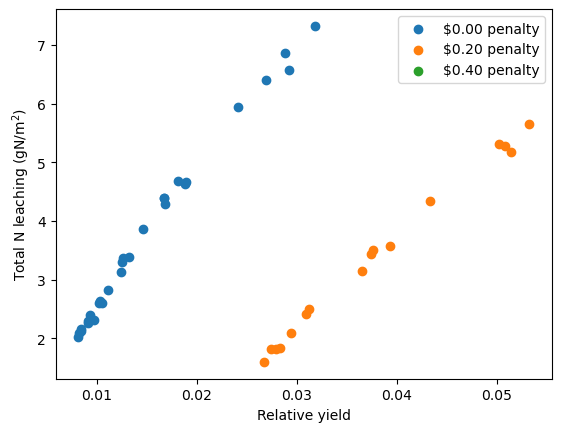

In [25]:
for idx, leaching_penalty_idx in enumerate(leaching_penalty_indicies):
    leaching_penalty_USD = main.LEACHING_PENALTIES_USD_PER_M2[leaching_penalty_idx]
    plt.scatter(extreme_results[extreme_results["penalty"] == leaching_penalty_USD]["deficit_cost"], extreme_results[extreme_results["penalty"] == leaching_penalty_USD]["total_leaching_gN_per_m2"], label="${:04.2f} penalty".format(leaching_penalty_USD))
    # plt.scatter(1.0 - (batch_rollout_results[idx * num_rollouts_batch:(idx + 1) * num_rollouts_batch, 1] / main.N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 / main.CORN_PRICE_USD_PER_G_GRAIN), batch_rollout_results[idx * num_rollouts_batch:(idx + 1) * num_rollouts_batch, 2], label="${:04.2f} penalty".format(leaching_penalty_USD))
plt.legend()
plt.xlabel("Relative yield")
plt.ylabel("Total N leaching (gN/$\\text{m}^2$)")
plt.savefig("rollouts_comparison.png", transparent=True, dpi=300, bbox_inches='tight')

In [26]:
plt.violinplot(np.transpose(batch_rollout_results[:, :, 1]))

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [ ]:
plt.scatter(batch_rollout_results[0, :, 0] / main.N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 / main.CORN_PRICE_USD_PER_G_GRAIN, batch_rollout_results[0, :, 1])

In [ ]:
plt.scatter(batch_rollout_results[2, :, 0] / main.N_SUFFICIENT_YIELD_G_GRAIN_PER_M2 / main.CORN_PRICE_USD_PER_G_GRAIN, batch_rollout_results[2, :, 1])

In [ ]:
np.average(batch_rollout_results[0, :, 1])

In [ ]:
np.average(batch_rollout_results[2, :, 1])

In [ ]:
np.sum(batch_rollout_results[:, :, 2], axis=1)